# RSNA Screening Mammography Breast Cancer Detection
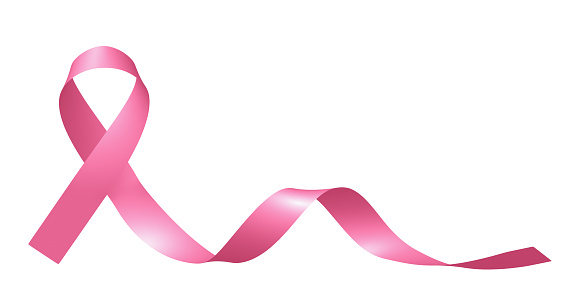

[train/test]_images/[patient_id]/[image_id].dcm The mammograms, in dicom format. You can expect roughly 8,000 patients in the hidden test set. There are usually but not always 4 images per patient. Note that many of the images use the jpeg 2000 format which may you may need special libraries to load.

**[train/test].csv** Metadata for each patient and image. Only the first few rows of the test set are available for download.

  - site_id - ID code for the source hospital.
  - patient_id - ID code for the patient.
  - image_id - ID code for the image.
  - laterality - Whether the image is of the left or right breast.
  - view - The orientation of the image. The default for a screening exam is to - capture two views per breast.
  - age - The patient's age in years.
  - implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
  - density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
  - machine_id - An ID code for the imaging device.
  - cancer - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
  - biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
  - invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
  - BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
  - prediction_id - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
  - difficult_negative_case - True if the case was unusually difficult. Only provided for train.

In [ ]:
# !kaggle competitions download -c rsna-breast-cancer-detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pydicom
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import plotly.express as px

import sklearn
import imblearn
from sklearn import tree
from sklearn import ensemble
from sklearn import neural_network

from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,classification_report
from sklearn.feature_selection import SelectKBest,SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE

import pickle 

import os
import cv2

# !pip install pylibjpeg
# import pylibjpeg

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Metadata Study

In [3]:
# Meta Data Import
Train_df=pd.read_csv('/content/drive/My Drive/CIS508/BreastCancerKaggle/train.csv')
Test_df=pd.read_csv('/content/drive/My Drive/CIS508/BreastCancerKaggle/test.csv')

In [4]:
Train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [5]:
Test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [6]:
Train_df['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

# CNN Model Development

- Training Set Creation : 2D Datasets using 256 x 256 PNG Files
- Save Sample Train_df 3158 
- Model Development & Training
- Converting Test DICOM to PNG and creating Testing Set for Submission file
- Submission file save


In [18]:
# Extracting few samples from dataset fro Training Purpose
class0=Train_df[Train_df['cancer']==0].copy()
class1=Train_df[Train_df['cancer']==1].copy()

def selectsample(class0,class1,n):
  # Class0=n
  # Class1=1158
  temp=class0.sample(n).copy()
  temp=temp.append(class1)
  return temp

# With 2000 class0 and 1158 class1 samples
Train_df_sample=selectsample(class0,class1,2000)

# Creating a dict for creating label for each image
imageid=Train_df_sample['image_id'].tolist()
cancer=Train_df_sample['cancer'].tolist()
mydict=dict(zip(imageid,cancer))

len(Train_df_sample)

3158

In [ ]:
# Using 256 x 256 png images from Kaggle
# Unzip png images and convert to a Train and Test Folder with PatientId folders and all images with name as imageid as mentioned in .csv files
# Inefficient
def create_trainset():
  training_data=[]
  currentdir=os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle')

# For each patient in Training Dataset
  for pat in os.listdir(os.path.join(currentdir,'train_images_processed_cv2_256')):
  #  print('Patient Folder:',pat)
    path=os.path.join(currentdir,'train_images_processed_cv2_256',pat)

    for myimage in os.listdir(path):
  #    print(' Working on Image Id : ',myimage)
      if int(myimage[:-4]) in Train_df_sample['image_id'].tolist():
        image=cv2.imread(os.path.join(path,myimage),cv2.IMREAD_GRAYSCALE)

        # plt.imshow(image,cmap='binary')
        # plt.title(str(myimage)+' '+str(mydict[ int(myimage[:-4]) ] ) )

        print('In sample')
        training_data.append([image,mydict[int(myimage[:-4])]])
        
  print('COMPLETE')
  
create_trainset()

In [ ]:
len(training_data)

In [ ]:
def featuretarget(training_data):
  IMG_PX_SIZE=256
  X=[]
  Y=[]
  for features,target in training_data:
    X.append(features)
    Y.append(target)
  X=np.array(X).reshape(-1,IMG_PX_SIZE,IMG_PX_SIZE,1)
  Y=np.array(Y)
  return X,Y

X,Y=featuretarget(training_data)

# Saving data as pickle 
import pickle 

pickle_out=open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/X_2000.pickle'),"wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out=open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/Y_2000.pickle'),"wb")
pickle.dump(Y,pickle_out)
pickle_out.close()

In [22]:
# Load pickle dataset 
X=pickle.load(open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/X_2000.pickle'),'rb'))
Y=pickle.load(open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/Y_2000.pickle'),'rb'))
len(X),len(Y)

(3158, 3158)

In [23]:
X.shape[1:]

(256, 256, 1)

In [24]:
# import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Flatten,Dense,Dropout,Activation
from keras.utils import normalize

In [25]:
model1=Sequential()

model1.add(Conv2D(64,(3,3),input_shape=X.shape[1:],activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(3,3)))

#Input layer
model1.add(Flatten())
#Hidden Layer
model1.add(Dense(64))
#Output Layer
model1.add(Dense(1,activation='sigmoid'))

In [26]:
X=normalize(X)

model1.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model1.fit(X,Y,batch_size=32,validation_split=0.1,verbose=1,epochs=3)

Epoch 1/3
89/89 [==============================] - 506s 6s/step - loss: 0.8750 - accuracy: 0.6277 - val_loss: 0.6668 - val_accuracy: 0.6171
Epoch 2/3
89/89 [==============================] - 460s 5s/step - loss: 0.6277 - accuracy: 0.6446 - val_loss: 0.6725 - val_accuracy: 0.6266
Epoch 3/3
89/89 [==============================] - 428s 5s/step - loss: 0.5865 - accuracy: 0.6865 - val_loss: 0.6935 - val_accuracy: 0.5665


In [27]:
model1.save('BreastDetectionBaseCNN.model')

In [29]:
# Load the pre-saved Model from Keras
model1=keras.models.load_model('BreastDetectionBaseCNN.model')

In [30]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 107584)            0         
                                                                 
 dense (Dense)               (None, 64)                6

## Validating the Test Images

In [68]:
# Data Conversion from DICOM to JPEG
import pydicom as dicom
import numpy as np
from PIL import Image
import os
from skimage.transform import resize

def convert(myimage):
    im = dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_test/'+myimage)
    im = im.pixel_array.astype(float)
    IMG_PX_SIZE=256
    resized_img=resize(im,(IMG_PX_SIZE,IMG_PX_SIZE),anti_aliasing=True)

    rescaled_image = (np.maximum(resized_img,0)/resized_img.max()) * 255 # float pixel
    final_image = np.uint8(rescaled_image) # integers pixels
    final_image = Image.fromarray(final_image)
    return final_image


path="/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_test"
ct_images = os.listdir(path)
arr_filename = [x for x in ct_images if x.endswith(".dcm")]

for name in arr_filename:
    image = convert(name)
    image.save('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_test/'+name[0:-4]+'.png')

In [69]:
# Create Test Set for Validation
test_set=[]
currentdir=os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle')
testpngimages=[i for i in os.listdir(os.path.join(currentdir,'image_test')) if i.endswith('.png')]

for myimage in testpngimages:
  image=cv2.imread(os.path.join(currentdir,'image_test',myimage),cv2.IMREAD_GRAYSCALE)
  test_set.append(image)

In [70]:
test_set[0].shape

(256, 256)

In [71]:
test_set=normalize(test_set)
predictions=model1.predict(test_set)
predictions

1/1 [==============================] - 0s 257ms/step


In [83]:
submissions=pd.concat([Test_df['prediction_id'],pd.DataFrame(predictions,columns=['cancer'])],axis=1)

In [84]:
submissions.to_csv('/content/drive/MyDrive/CIS508/BreastCancerKaggle/BaseCNNSubmission.csv')

Extra Code

https://www.kaggle.com/datasets/radek1/rsna-mammography-images-as-pngs/code
<br>
Convert to png 

In [ ]:
# Unzip the 256 x 256 png converted files (Only first time)
# !unzip /content/drive/MyDrive/CIS508/BreastCancerKaggle/images_as_pngs_cv2_256.zip -d /content/drive/MyDrive/CIS508/BreastCancerKaggle/

In [ ]:
# #Unzip data and convert to a Train and Test FOlder with PatientId folders and all images with name as imageid as mentioned in .csv files
# from skimage.transform import resize
# training_data=[]

# currentdir=os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle')
# currentdir

# # For each patient in Training Dataset
# for pat in os.listdir(os.path.join(currentdir,'image_train')):
#   print('Patient Folder:',pat)
#   path=os.path.join(currentdir,'image_train',pat)

#   for myimage in os.listdir(path):
#     print(' Working on Image Id : ',myimage)
#     #--------------------------------------------------------------------------------------------------------------------------------------------#
#     # Without downsizing

#     # print(myimage)
#     # image=dicom.dcmread(os.path.join(path,myimage))
#     # plt.figure(figsize=(10,10))
#     # plt.title(str(myimage)+' '+str(image.pixel_array.shape)+str(mydict[ int(myimage[:-4]) ] ) )
#     # plt.imshow(image.pixel_array)

#     # training_data.append([image.pixel_array,mydict[int(myimage[:-4])]])

#     #--------------------------------------------------------------------------------------------------------------------------------------------#
#     # With downsizing
#     ds=dicom.dcmread(os.path.join(path,myimage))
#     # get the pixel information into a numpy array
#     data=ds.pixel_array
#     # print('The image has {} x {} voxels'.format(data.shape[0],
#     #                                             data.shape[1]))
    
#     data_downsampling = data[::8, ::8]
#     # print('The downsampled image has {} x {} voxels'.format(
#     #     data_downsampling.shape[0], data_downsampling.shape[1]))
    
#     # Reducing Image Size to 512 x 512
#     IMG_PX_SIZE = 512
#     data_downsampling=resize(data_downsampling,(IMG_PX_SIZE,IMG_PX_SIZE),anti_aliasing=True)

#     # copy the data back to the original data set
#     ds.PixelData = data_downsampling.tobytes()
#     # update the information regarding the shape of the data array
#     ds.Rows, ds.Columns = data_downsampling.shape

#     # plt.figure(figsize=(10,10))
#     # plt.title(str(myimage)+' '+str(data_downsampling.shape)+str(mydict[ int(myimage[:-4]) ] ) )
#     # plt.imshow(data_downsampling)
#     # print(ds)
#     training_data.append([data_downsampling,mydict[int(myimage[:-4])]])

# # Image Size is constant 5355 x 4915
# # Downsizing applied to convert to 670 x 615

In [ ]:
# Trying to debug the pixel_array issue arising for cancerous images
# With downsizing
# !pip install pylibjpeg
# !pip install -U python-gdcm
# import pylibjpeg
# import gdcm

# import pydicom.pixel_data_handlers.pylibjpeg_handler as dicpx
# from pydicom.pixel_data_handlers import pillow_handler,pylibjpeg_handler,gdcm_handler

# pillow_handler.PillowJPEGTransferSyntaxes.append('1.2.840.10008.1.2.4.70')
# pylibjpeg_handler.supports_transfer_syntax('1.2.840.10008.1.2.4.70')
# gdcm_handler.supports_transfer_syntax('1.2.840.10008.1.2.4.70')

# ds=dicom.dcmread(os.path.join(path,myimage))

# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/100006/1459541791.dcm')

#10130 Trail
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/2110820077.dcm') #Non Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/1013166704.dcm') #Non Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/1165309236.dcm') #Non Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/1360338805.dcm') #Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/1672636630.dcm') #Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/388811999.dcm') #Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/613462606.dcm') #Cancerous not ok

# 106 Trail
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/106/1160585918.dcm') #Non Cancerous ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/106/1495797827.dcm') #Non Cancerous ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/106/2018825992.dcm') #Cancerous ok 
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/106/76321767.dcm') #Cancerous ok

# ds
# ds.file_meta.
# dir(ds)
# ds.pixel_array
# myimage
# pylibjpeg_handler.       

# Transfer Learning Model
- Training Set Creation : 3D Datasets using 256 x 256 PNG Files
- Save Sample Train_df 3158 3D  
- Model Development & Training : Xception, vgg, resnet
- Converting Test DICOM to PNG and creating Testing Set for Submission file with 3 dimensions
- Submission file save

In [7]:
#import keras
import tensorflow as tf 
from tensorflow import keras
import tensorflow.keras as K

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

import pandas as pd
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
#from keras.utils import np_utils
from keras import utils as np_utils
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

pd.set_option('display.max_columns',None)#displaying long list of columns
pd.set_option('display.max_rows', None)#displaying long list of rows
pd.set_option('display.width', 1000)#width of window

In [ ]:
# Generate 3D data points for Xception Model

training_data_3d=[]
currentdir=os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle')

# For each patient in Training Dataset
for pat in os.listdir(os.path.join(currentdir,'train_images_processed_cv2_256')):
  path=os.path.join(currentdir,'train_images_processed_cv2_256',pat)

  for myimage in os.listdir(path):
    if int(myimage[:-4]) in Train_df_sample['image_id'].tolist():
      image=cv2.imread(os.path.join(path,myimage))
      training_data_3d.append([image,mydict[int(myimage[:-4])]])

print('COMPLETE')

In [ ]:
print(training_data_3d[0][0].shape) # Image Matrix 3D
print(training_data_3d[0][1]) # Cancer/NonCancer target

In [ ]:
# Function already defined above
def featuretarget(training_data):
  IMG_PX_SIZE=256
  X=[]
  Y=[]
  for features,target in training_data:
    X.append(features)
    Y.append(target)
  X=np.array(X).reshape(-1,IMG_PX_SIZE,IMG_PX_SIZE,3)
  Y=np.array(Y)
  return X,Y
X_3d,Y_3d=featuretarget(training_data_3d)

# Saving data as pickle 
import pickle 

pickle_out=open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/X_2000_3D.pickle'),"wb")
pickle.dump(X_3d,pickle_out)
pickle_out.close()

pickle_out=open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/Y_2000_3D.pickle'),"wb")
pickle.dump(Y_3d,pickle_out)
pickle_out.close()

In [8]:
# Load pickle dataset 
X_3d=pickle.load(open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/X_2000_3D.pickle'),'rb'))
Y_3d=pickle.load(open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/Y_2000_3D.pickle'),'rb'))
len(X_3d),len(Y_3d)

(3158, 3158)

In [9]:
X_3d.shape,Y_3d.shape

((3158, 256, 256, 3), (3158,))

In [10]:
def preprocess_data(X,Y):
  X_p = K.applications.xception.preprocess_input(X)
  Y_p = K.utils.to_categorical(Y,2)
  return X_p, Y_p

In [11]:
# load and split data
# The data, split between train and test sets:
# (x_train, y_train), (x_test, y_test) = K.datasets.cifar100.load_data()
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols = 256, 256
print('x_train shape:', X_3d.shape)
print('y_train shape:', Y_3d.shape)

x_train shape: (3158, 256, 256, 3)
y_train shape: (3158,)


In [12]:
x_train, y_train = preprocess_data(X_3d, Y_3d)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (3158, 256, 256, 3)
y_train shape: (3158, 2)


In [13]:
input_t = K.Input(shape=(256,256,3))
# input_t = K.Input(shape=(224,224,3))
# input_t = K.Input(shape=(32,32,3))
xception_model = K.applications.Xception(include_top=False,
                                    weights="imagenet",
                                    input_tensor=input_t)

83683744/83683744 [==============================] - 3s 0us/step


In [9]:
for layer in xception_model.layers[:95]:
  layer.trainable=False

In [145]:
for i, layer in enumerate(xception_model.layers):
  print(i,layer.name,"-",layer.trainable)

0 input_4 - False
1 block1_conv1 - False
2 block1_conv1_bn - False
3 block1_conv1_act - False
4 block1_conv2 - False
5 block1_conv2_bn - False
6 block1_conv2_act - False
7 block2_sepconv1 - False
8 block2_sepconv1_bn - False
9 block2_sepconv2_act - False
10 block2_sepconv2 - False
11 block2_sepconv2_bn - False
12 conv2d_14 - False
13 block2_pool - False
14 batch_normalization_12 - False
15 add_36 - False
16 block3_sepconv1_act - False
17 block3_sepconv1 - False
18 block3_sepconv1_bn - False
19 block3_sepconv2_act - False
20 block3_sepconv2 - False
21 block3_sepconv2_bn - False
22 conv2d_15 - False
23 block3_pool - False
24 batch_normalization_13 - False
25 add_37 - False
26 block4_sepconv1_act - False
27 block4_sepconv1 - False
28 block4_sepconv1_bn - False
29 block4_sepconv2_act - False
30 block4_sepconv2 - False
31 block4_sepconv2_bn - False
32 conv2d_16 - False
33 block4_pool - False
34 batch_normalization_14 - False
35 add_38 - False
36 block5_sepconv1_act - False
37 block5_sepconv

In [14]:
to_res = (256, 256)

model2 = K.models.Sequential()
model2.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res))) 
model2.add(xception_model)
model2.add(K.layers.Flatten())
model2.add(K.layers.BatchNormalization())
model2.add(K.layers.Dense(256, activation='relu'))
model2.add(K.layers.Dropout(0.1))
model2.add(K.layers.BatchNormalization())
model2.add(K.layers.Dense(128, activation='relu'))
model2.add(K.layers.Dropout(0.1))
model2.add(K.layers.BatchNormalization())
# model.add(K.layers.Dense(64, activation='relu'))
# model.add(K.layers.Dropout(0.1))
# model.add(K.layers.BatchNormalization())
model2.add(K.layers.Dense(2, activation='softmax'))

In [15]:
# Compile model and train
# Results
# In the 8th epoch, the values are very similar and it is interesting to note that 
# in the first validation accuracy is higher than training. 
# This is because of dropout use, which in Keras, it has a different behavior 
# for training and testing. In testing time, all the features are ready and 
# the dropout is turned off, resulting in a better accuracy. 
# This readjust on the last epochs since the model continues changing on the training.

model2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
history = model2.fit(x_train, y_train, batch_size=32, epochs=5, verbose=1)
model2.summary()

Epoch 1/5
99/99 [==============================] - 96s 795ms/step - loss: 0.7860 - accuracy: 0.5507
Epoch 2/5
99/99 [==============================] - 80s 804ms/step - loss: 0.7181 - accuracy: 0.5956
Epoch 3/5
99/99 [==============================] - 80s 812ms/step - loss: 0.7089 - accuracy: 0.5915
Epoch 4/5
99/99 [==============================] - 80s 804ms/step - loss: 0.6979 - accuracy: 0.6115
Epoch 5/5
99/99 [==============================] - 79s 803ms/step - loss: 0.6982 - accuracy: 0.6111
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                  

In [62]:
# Create Test Set for Validation
test_set_3d=[]
img_order=[]
currentdir=os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle')
testpngimages=[i for i in os.listdir(os.path.join(currentdir,'image_test')) if i.endswith('.png')]

for myimage in testpngimages:
  image=cv2.imread(os.path.join(currentdir,'image_test',myimage))
  img_order.append(myimage[:-4])
  test_set_3d.append(image)

In [66]:
img_order

['68070693', '361203119', '736471439', '1591370361']

In [19]:
test_set_3d[0].shape

(256, 256, 3)

In [29]:
IMG_PX_SIZE=256
test_set_3d=np.array(test_set_3d).reshape(-1,IMG_PX_SIZE,IMG_PX_SIZE,3)
predictions=model2.predict(test_set_3d)
predictions[0]

1/1 [==============================] - 0s 29ms/step


array([[9.9599349e-01, 4.0064817e-03],
       [9.9994075e-01, 5.9225877e-05],
       [9.9999988e-01, 1.5486947e-07],
       [1.0000000e+00, 5.7451666e-09]], dtype=float32)

In [70]:
submission=pd.DataFrame(predictions,columns=['NoCancer','Cancer'])
submission['img_order']=list(map(int, img_order))
submission

,NoCancer,Cancer,img_order
0,0.995993,4.006482e-03,68070693
1,0.999941,5.922588e-05,361203119
2,1.000000,1.548695e-07,736471439
3,1.000000,5.745167e-09,1591370361


In [54]:
Test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [77]:
Test_df.merge(submission,left_on='image_id',right_on='img_order')[['prediction_id','Cancer']].to_csv('/content/drive/MyDrive/CIS508/BreastCancerKaggle/XceptionSubmission.csv')

# CNN + Meta data : With layer extraction

# Transfer Learning + meta Data: With layer extraction

# Rough

(256, 256)

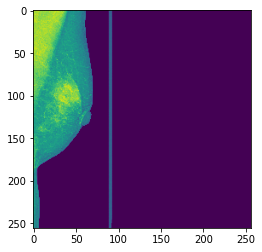

In [96]:
image=cv2.imread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/train_images_processed_cv2_256/10006/1459541791.png',cv2.IMREAD_GRAYSCALE)
image=cv2.imread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/train_images_processed_cv2_256/10006/1459541791.png')

plt.imshow(image)
image.shape